#Colab Friendly Notebook

In [1]:
#pip install -r /content/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 132.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 133.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 95.1

In [9]:
#@title Environment Setup
import pandas as pd
import numpy as np
import hashlib
import io
import os
import sys
from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import Dict, Iterable, Optional, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import imagehash
from tqdm import tqdm

import matplotlib.pyplot as plt
# Show plots inline
%matplotlib inline

from PIL import Image, UnidentifiedImageError
from tqdm.auto import tqdm


In [10]:
#@title Mount Google Drive
CURATE_TO_DRIVE = True

if CURATE_TO_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_OUT = "/content/drive/MyDrive/herpeton"
else:
    BASE_OUT = "/content/herpeton"

os.makedirs(BASE_OUT, exist_ok=True)

# Controls to keep runtime reasonable
MAX_RECORDS = 15000          # hard cap across the stream (increase if you have time/compute)
SAMPLE_PER_SPECIES = 120     # images per species to collect/curate/EDA
REPORT_DIR = os.path.join(BASE_OUT, "_reports")
os.makedirs(REPORT_DIR, exist_ok=True)

print(f"Output base: {BASE_OUT}")
print(f"Reports   : {REPORT_DIR}")
print(f"Limits    : MAX_RECORDS={MAX_RECORDS}, SAMPLE_PER_SPECIES={SAMPLE_PER_SPECIES}")

Mounted at /content/drive
Output base: /content/drive/MyDrive/herpeton
Reports   : /content/drive/MyDrive/herpeton/_reports
Limits    : MAX_RECORDS=15000, SAMPLE_PER_SPECIES=120


In [11]:
#@title Load Processed Dataset

# Paths to processed dataset
BASE_PATH = "/content/drive/MyDrive/herpeton/biotrove_processed"
IMG_DIR = os.path.join(BASE_PATH, "images")

# Load all CSVs
csv_files = [f for f in os.listdir(BASE_PATH) if f.endswith(".csv")]
csv_files

# Load CSVs
dfs = [pd.read_csv(os.path.join(BASE_PATH, f)) for f in csv_files]

# If there are multiple metadata CSVs, merge them on common columns
# Otherwise take the first one
if len(dfs) == 1:
    df = dfs[0]
else:
    # Try automatic merge: assumes shared columns
    common_cols = list(set(dfs[0].columns).intersection(*[set(d.columns) for d in dfs]))
    df = dfs[0]
    for d in dfs[1:]:
        df = df.merge(d, on=common_cols, how="outer")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (2014, 14)


photo_id         scientificName   kingdom    phylum     class     order  \
0     10032  Elgaria multicarinata  Animalia  Chordata  Reptilia  Squamata   
1     10033  Elgaria multicarinata  Animalia  Chordata  Reptilia  Squamata   
2     10042   Sceloporus graciosus  Animalia  Chordata  Reptilia  Squamata   
3    100487    Thamnophis sirtalis  Animalia  Chordata  Reptilia  Squamata   
4    100555   Anolis apletophallus  Animalia  Chordata  Reptilia  Squamata   

            family       genus        species                common_name  \
0         Anguidae     Elgaria  multicarinata  Southern Alligator Lizard   
1         Anguidae     Elgaria  multicarinata  Southern Alligator Lizard   
2  Phrynosomatidae  Sceloporus      graciosus           Sagebrush Lizard   
3       Colubridae  Thamnophis       sirtalis        Common Garter Snake   
4         Anolidae      Anolis  apletophallus          Panama City Anole   

  taxonRank                                          photo_url  \
0   species  http://inaturalist-open-data.s3.amazonaws.com/...   
1   species  http://inaturalist-open-data.s3.amazonaws.com/...   
2   species  http://inaturalist-open-data.s3.amazonaws.com/...   
3   species  http://inaturalist-open-data.s3.amazonaws.com/...   
4   species  http://inaturalist-open-data.s3.amazonaws.com/...   

                             image_path  \
0   biotrove_processed/images/10032.jpg   
1   biotrove_processed/images/10033.jpg   
2   biotrove_processed/images/10042.jpg   
3  biotrove_processed/images/100487.jpg   
4  biotrove_processed/images/100555.jpg   

                                    text_description  
0  Elgaria multicarinata (Southern Alligator Liza...  
1  Elgaria multicarinata (Southern Alligator Liza...  
2  Sceloporus graciosus (Sagebrush Lizard) - Phry...  
3  Thamnophis sirtalis (Common Garter Snake) - Co...  
4  Anolis apletophallus (Panama City Anole) - Ano...

In [13]:
#@title Validate Image Paths

# Ensure file path column exists
if "file_path" in df.columns:
    df["image_path"] = df["file_path"]
elif "image_path" in df.columns:
    pass
else:
    # Try to generate from filename column
    if "filename" in df.columns:
        df["image_path"] = IMG_DIR + "/" + df["filename"]
    else:
        raise ValueError("No image path column found!")

# Ensure image_path column contains only strings and handle NaN values
df["image_path"] = df["image_path"].astype(str).replace("nan", "")

# Check file existence
df["exists"] = df["image_path"].apply(lambda p: os.path.exists(p))
missing = df[~df["exists"]]

print("Missing images:", len(missing))
missing.head()

Missing images: 2014


photo_id         scientificName   kingdom    phylum     class     order  \
0     10032  Elgaria multicarinata  Animalia  Chordata  Reptilia  Squamata   
1     10033  Elgaria multicarinata  Animalia  Chordata  Reptilia  Squamata   
2     10042   Sceloporus graciosus  Animalia  Chordata  Reptilia  Squamata   
3    100487    Thamnophis sirtalis  Animalia  Chordata  Reptilia  Squamata   
4    100555   Anolis apletophallus  Animalia  Chordata  Reptilia  Squamata   

            family       genus        species                common_name  \
0         Anguidae     Elgaria  multicarinata  Southern Alligator Lizard   
1         Anguidae     Elgaria  multicarinata  Southern Alligator Lizard   
2  Phrynosomatidae  Sceloporus      graciosus           Sagebrush Lizard   
3       Colubridae  Thamnophis       sirtalis        Common Garter Snake   
4         Anolidae      Anolis  apletophallus          Panama City Anole   

  taxonRank                                          photo_url  \
0   species  http://inaturalist-open-data.s3.amazonaws.com/...   
1   species  http://inaturalist-open-data.s3.amazonaws.com/...   
2   species  http://inaturalist-open-data.s3.amazonaws.com/...   
3   species  http://inaturalist-open-data.s3.amazonaws.com/...   
4   species  http://inaturalist-open-data.s3.amazonaws.com/...   

                             image_path  \
0   biotrove_processed/images/10032.jpg   
1   biotrove_processed/images/10033.jpg   
2   biotrove_processed/images/10042.jpg   
3  biotrove_processed/images/100487.jpg   
4  biotrove_processed/images/100555.jpg   

                                    text_description  exists  
0  Elgaria multicarinata (Southern Alligator Liza...   False  
1  Elgaria multicarinata (Southern Alligator Liza...   False  
2  Sceloporus graciosus (Sagebrush Lizard) - Phry...   False  
3  Thamnophis sirtalis (Common Garter Snake) - Co...   False  
4  Anolis apletophallus (Panama City Anole) - Ano...   False

In [26]:
#@title Helper function to show random images
def show_random_images(df_subset, n=12):
    if 'image_path' not in df_subset.columns:
        print("DataFrame does not contain an 'image_path' column.")
        return

    num_samples = min(n, len(df_subset))
    if num_samples == 0:
        print("No images to display from the provided DataFrame subset.")
        return

    # Use random_state for reproducibility in sampling
    sample_paths_relative = df_subset["image_path"].sample(num_samples, random_state=42).tolist()

    cols = 4
    rows = (num_samples + cols - 1) // cols

    plt.figure(figsize=(15, rows * 4))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)

    for i, relative_path in enumerate(sample_paths_relative):
        # Construct the full absolute path using BASE_OUT
        full_path = os.path.join(BASE_OUT, relative_path)
        try:
            img = Image.open(full_path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.axis("off")
        except FileNotFoundError:
            print(f"File not found: {full_path}")
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, "Image Not Found", horizontalalignment='center', verticalalignment='center', fontsize=10)
            plt.axis("off")
        except UnidentifiedImageError:
            print(f"Cannot identify image file: {full_path}")
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, "Corrupt Image", horizontalalignment='center', verticalalignment='center', fontsize=10)
            plt.axis("off")
        except Exception as e:
            print(f"Error loading image {full_path}: {e}")
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, f"Error: {str(e)[:20]}...", horizontalalignment='center', verticalalignment='center', fontsize=10)
            plt.axis("off")

    plt.suptitle("Sample Images", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

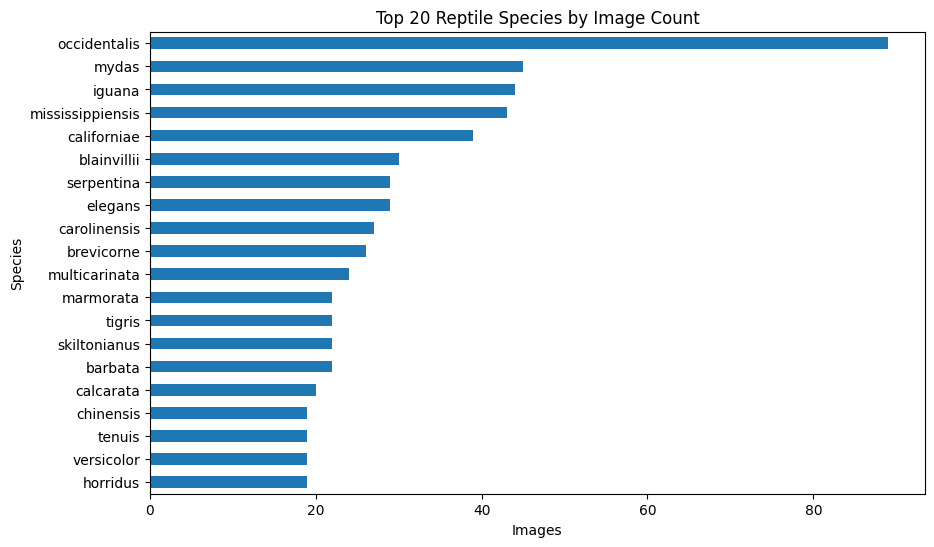

count    425.000000
mean       4.738824
std        7.475117
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       89.000000
Name: count, dtype: float64

In [14]:
#@title Species Distribution EDA
species_counts = df["species"].value_counts()

plt.figure(figsize=(10, 6))
species_counts.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Reptile Species by Image Count")
plt.xlabel("Images")
plt.ylabel("Species")
plt.show()

species_counts.describe()

In [27]:
#@title Visualize Sample Images From a Specific Species
species_list = df["species"].unique()
species_list[:20]

def show_species_samples(df, species, n=12):
    subset = df[df["species"] == species]
    sample_paths = subset["image_path"].sample(min(n, len(subset))).tolist()

    cols = 4
    rows = n // cols + 1

    plt.figure(figsize=(15, 12))
    for i, path in enumerate(sample_paths):
        try:
            img = Image.open(path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.axis("off")
        except:
            pass
    plt.suptitle(f"Samples of Species: {species}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example:
show_species_samples(df, species=species_list[0], n=12)

<Figure size 1500x1200 with 0 Axes>

In [19]:
#@title Show Samples from the MOST COMMON Species
top_species = df["species"].value_counts().idxmax()
print("Most common species:", top_species)

show_species_samples(df, species=top_species, n=12)

Most common species: occidentalis


<Figure size 1500x1200 with 0 Axes>

In [33]:
#@title Show Samples from the RAREST Species
rare_species = df["species"].value_counts().idxmin()
print("Rarest species:", rare_species)

show_species_samples(df, species=rare_species, n=12)

Rarest species: jaculus


<Figure size 1500x1200 with 0 Axes>

In [34]:
#@title Random Species Sample
import random
def sample_random_species(df):
    species = random.choice(df["species"].unique())
    print("Random species selected:", species)
    show_species_samples(df, species=species, n=12)

# Try multiple times:
sample_random_species(df)

Random species selected: vibakari


<Figure size 1500x1200 with 0 Axes>

In [31]:
#@title Image Grid
def mosaic(df, n=25):
    sample_paths = df["image_path"].sample(n).tolist()
    plt.figure(figsize=(14, 14))

    for i, p in enumerate(sample_paths):
        try:
            img = Image.open(p)
            plt.subplot(5, 5, i+1)
            plt.imshow(img)
            plt.axis("off")
        except:
            pass

    plt.suptitle("Random Mosaic of Reptilia Images", fontsize=16)
    plt.tight_layout()
    plt.show()

mosaic(df, n=25)

<Figure size 1400x1400 with 0 Axes>

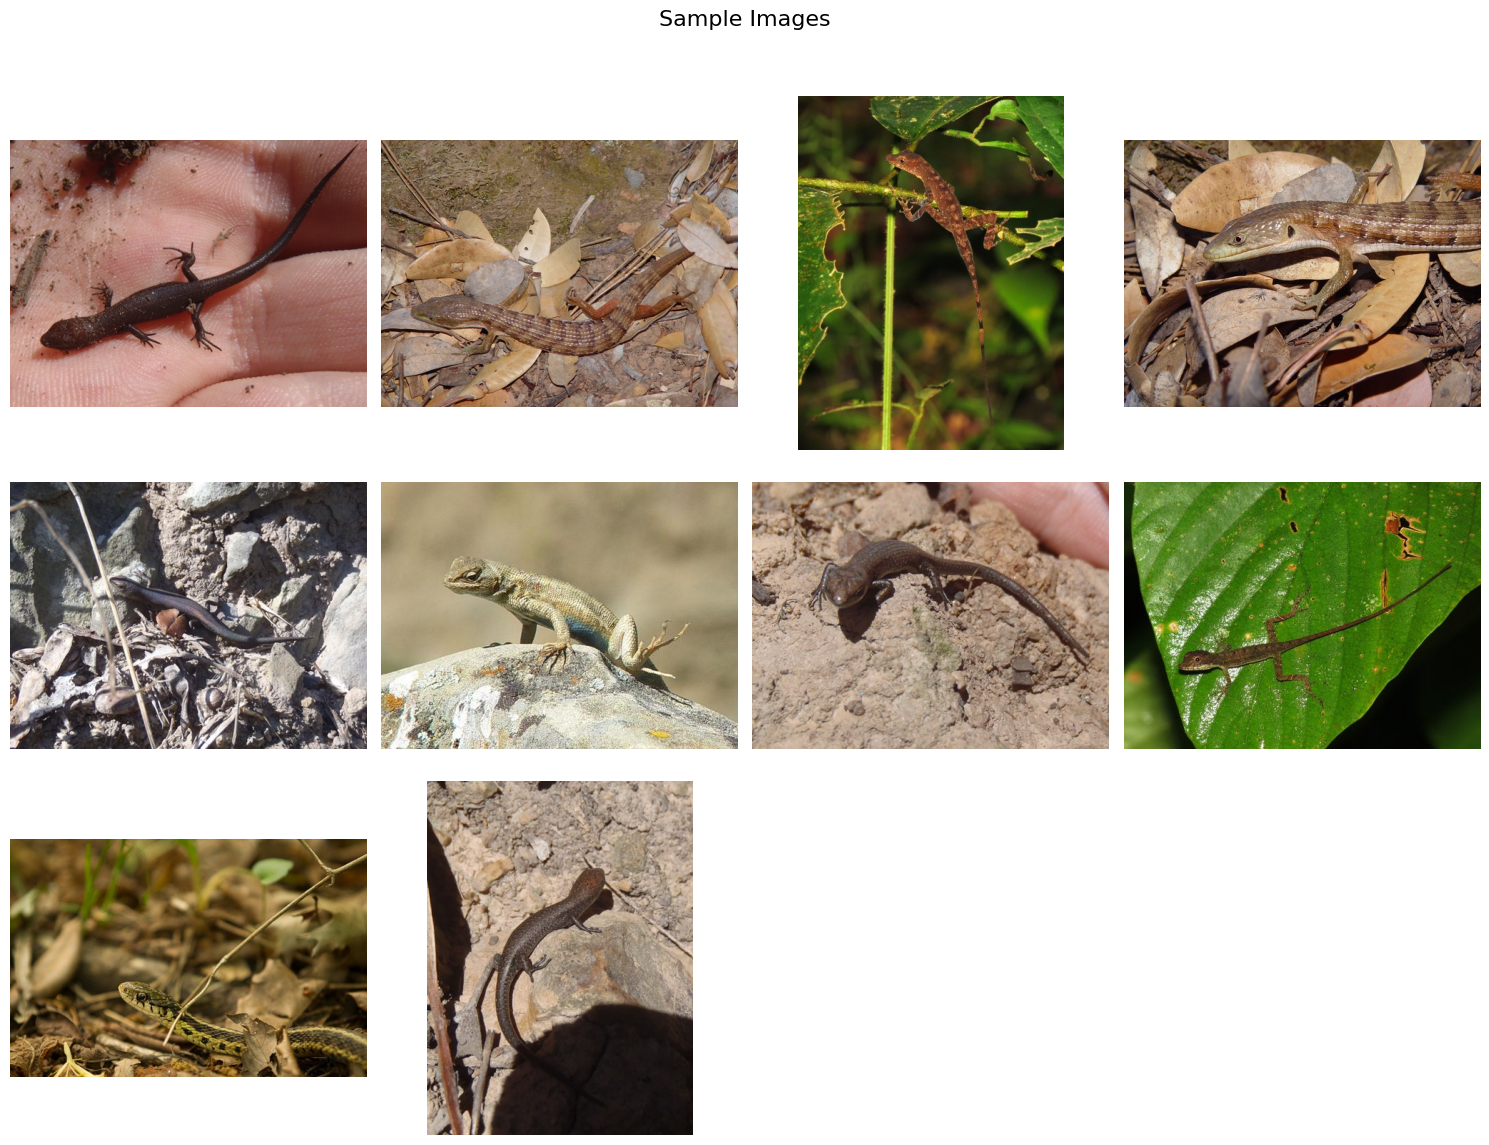

In [28]:
#@title Check for Outliers - Small
df_small = df.sort_values(by=["width", "height"]).head(10)
df_small

show_random_images(df_small, n=min(10, len(df_small)))



Wide images:


photo_id           scientificName   kingdom    phylum     class     order  \
0     10032    Elgaria multicarinata  Animalia  Chordata  Reptilia  Squamata   
1     10033    Elgaria multicarinata  Animalia  Chordata  Reptilia  Squamata   
2     10042     Sceloporus graciosus  Animalia  Chordata  Reptilia  Squamata   
3    100487      Thamnophis sirtalis  Animalia  Chordata  Reptilia  Squamata   
4    100555     Anolis apletophallus  Animalia  Chordata  Reptilia  Squamata   
5    100556     Anolis apletophallus  Animalia  Chordata  Reptilia  Squamata   
6    100975  Lampropholis guichenoti  Animalia  Chordata  Reptilia  Squamata   
7    100976  Lampropholis guichenoti  Animalia  Chordata  Reptilia  Squamata   
8    100977  Lampropholis guichenoti  Animalia  Chordata  Reptilia  Squamata   
9    100978  Lampropholis guichenoti  Animalia  Chordata  Reptilia  Squamata   

            family         genus        species                   common_name  \
0         Anguidae       Elgaria  multicarinata     Southern Alligator Lizard   
1         Anguidae       Elgaria  multicarinata     Southern Alligator Lizard   
2  Phrynosomatidae    Sceloporus      graciosus              Sagebrush Lizard   
3       Colubridae    Thamnophis       sirtalis           Common Garter Snake   
4         Anolidae        Anolis  apletophallus             Panama City Anole   
5         Anolidae        Anolis  apletophallus             Panama City Anole   
6        Scincidae  Lampropholis     guichenoti  Pale-flecked Garden Sunskink   
7        Scincidae  Lampropholis     guichenoti  Pale-flecked Garden Sunskink   
8        Scincidae  Lampropholis     guichenoti  Pale-flecked Garden Sunskink   
9        Scincidae  Lampropholis     guichenoti  Pale-flecked Garden Sunskink   

  taxonRank                                          photo_url  \
0   species  http://inaturalist-open-data.s3.amazonaws.com/...   
1   species  http://inaturalist-open-data.s3.amazonaws.com/...   
2   species  http://inaturalist-open-data.s3.amazonaws.com/...   
3   species  http://inaturalist-open-data.s3.amazonaws.com/...   
4   species  http://inaturalist-open-data.s3.amazonaws.com/...   
5   species  http://inaturalist-open-data.s3.amazonaws.com/...   
6   species  http://inaturalist-open-data.s3.amazonaws.com/...   
7   species  http://inaturalist-open-data.s3.amazonaws.com/...   
8   species  http://inaturalist-open-data.s3.amazonaws.com/...   
9   species  http://inaturalist-open-data.s3.amazonaws.com/...   

                             image_path  \
0   biotrove_processed/images/10032.jpg   
1   biotrove_processed/images/10033.jpg   
2   biotrove_processed/images/10042.jpg   
3  biotrove_processed/images/100487.jpg   
4  biotrove_processed/images/100555.jpg   
5  biotrove_processed/images/100556.jpg   
6  biotrove_processed/images/100975.jpg   
7  biotrove_processed/images/100976.jpg   
8  biotrove_processed/images/100977.jpg   
9  biotrove_processed/images/100978.jpg   

                                    text_description  exists  width  height  \
0  Elgaria multicarinata (Southern Alligator Liza...   False    NaN     NaN   
1  Elgaria multicarinata (Southern Alligator Liza...   False    NaN     NaN   
2  Sceloporus graciosus (Sagebrush Lizard) - Phry...   False    NaN     NaN   
3  Thamnophis sirtalis (Common Garter Snake) - Co...   False    NaN     NaN   
4  Anolis apletophallus (Panama City Anole) - Ano...   False    NaN     NaN   
5  Anolis apletophallus (Panama City Anole) - Ano...   False    NaN     NaN   
6  Lampropholis guichenoti (Pale-flecked Garden S...   False    NaN     NaN   
7  Lampropholis guichenoti (Pale-flecked Garden S...   False    NaN     NaN   
8  Lampropholis guichenoti (Pale-flecked Garden S...   False    NaN     NaN   
9  Lampropholis guichenoti (Pale-flecked Garden S...   False    NaN     NaN   

   aspect_ratio phash  
0           NaN  None  
1           NaN  None  
2           NaN  None  
3           NaN  None  
4           NaN  None  
5           NaN

Tall images:


photo_id           scientificName   kingdom    phylum     class     order  \
0     10032    Elgaria multicarinata  Animalia  Chordata  Reptilia  Squamata   
1     10033    Elgaria multicarinata  Animalia  Chordata  Reptilia  Squamata   
2     10042     Sceloporus graciosus  Animalia  Chordata  Reptilia  Squamata   
3    100487      Thamnophis sirtalis  Animalia  Chordata  Reptilia  Squamata   
4    100555     Anolis apletophallus  Animalia  Chordata  Reptilia  Squamata   
5    100556     Anolis apletophallus  Animalia  Chordata  Reptilia  Squamata   
6    100975  Lampropholis guichenoti  Animalia  Chordata  Reptilia  Squamata   
7    100976  Lampropholis guichenoti  Animalia  Chordata  Reptilia  Squamata   
8    100977  Lampropholis guichenoti  Animalia  Chordata  Reptilia  Squamata   
9    100978  Lampropholis guichenoti  Animalia  Chordata  Reptilia  Squamata   

            family         genus        species                   common_name  \
0         Anguidae       Elgaria  multicarinata     Southern Alligator Lizard   
1         Anguidae       Elgaria  multicarinata     Southern Alligator Lizard   
2  Phrynosomatidae    Sceloporus      graciosus              Sagebrush Lizard   
3       Colubridae    Thamnophis       sirtalis           Common Garter Snake   
4         Anolidae        Anolis  apletophallus             Panama City Anole   
5         Anolidae        Anolis  apletophallus             Panama City Anole   
6        Scincidae  Lampropholis     guichenoti  Pale-flecked Garden Sunskink   
7        Scincidae  Lampropholis     guichenoti  Pale-flecked Garden Sunskink   
8        Scincidae  Lampropholis     guichenoti  Pale-flecked Garden Sunskink   
9        Scincidae  Lampropholis     guichenoti  Pale-flecked Garden Sunskink   

  taxonRank                                          photo_url  \
0   species  http://inaturalist-open-data.s3.amazonaws.com/...   
1   species  http://inaturalist-open-data.s3.amazonaws.com/...   
2   species  http://inaturalist-open-data.s3.amazonaws.com/...   
3   species  http://inaturalist-open-data.s3.amazonaws.com/...   
4   species  http://inaturalist-open-data.s3.amazonaws.com/...   
5   species  http://inaturalist-open-data.s3.amazonaws.com/...   
6   species  http://inaturalist-open-data.s3.amazonaws.com/...   
7   species  http://inaturalist-open-data.s3.amazonaws.com/...   
8   species  http://inaturalist-open-data.s3.amazonaws.com/...   
9   species  http://inaturalist-open-data.s3.amazonaws.com/...   

                             image_path  \
0   biotrove_processed/images/10032.jpg   
1   biotrove_processed/images/10033.jpg   
2   biotrove_processed/images/10042.jpg   
3  biotrove_processed/images/100487.jpg   
4  biotrove_processed/images/100555.jpg   
5  biotrove_processed/images/100556.jpg   
6  biotrove_processed/images/100975.jpg   
7  biotrove_processed/images/100976.jpg   
8  biotrove_processed/images/100977.jpg   
9  biotrove_processed/images/100978.jpg   

                                    text_description  exists  width  height  \
0  Elgaria multicarinata (Southern Alligator Liza...   False    NaN     NaN   
1  Elgaria multicarinata (Southern Alligator Liza...   False    NaN     NaN   
2  Sceloporus graciosus (Sagebrush Lizard) - Phry...   False    NaN     NaN   
3  Thamnophis sirtalis (Common Garter Snake) - Co...   False    NaN     NaN   
4  Anolis apletophallus (Panama City Anole) - Ano...   False    NaN     NaN   
5  Anolis apletophallus (Panama City Anole) - Ano...   False    NaN     NaN   
6  Lampropholis guichenoti (Pale-flecked Garden S...   False    NaN     NaN   
7  Lampropholis guichenoti (Pale-flecked Garden S...   False    NaN     NaN   
8  Lampropholis guichenoti (Pale-flecked Garden S...   False    NaN     NaN   
9  Lampropholis guichenoti (Pale-flecked Garden S...   False    NaN     NaN   

   aspect_ratio phash  
0           NaN  None  
1           NaN  None  
2           NaN  None  
3           NaN  None  
4           NaN  None  
5           NaN

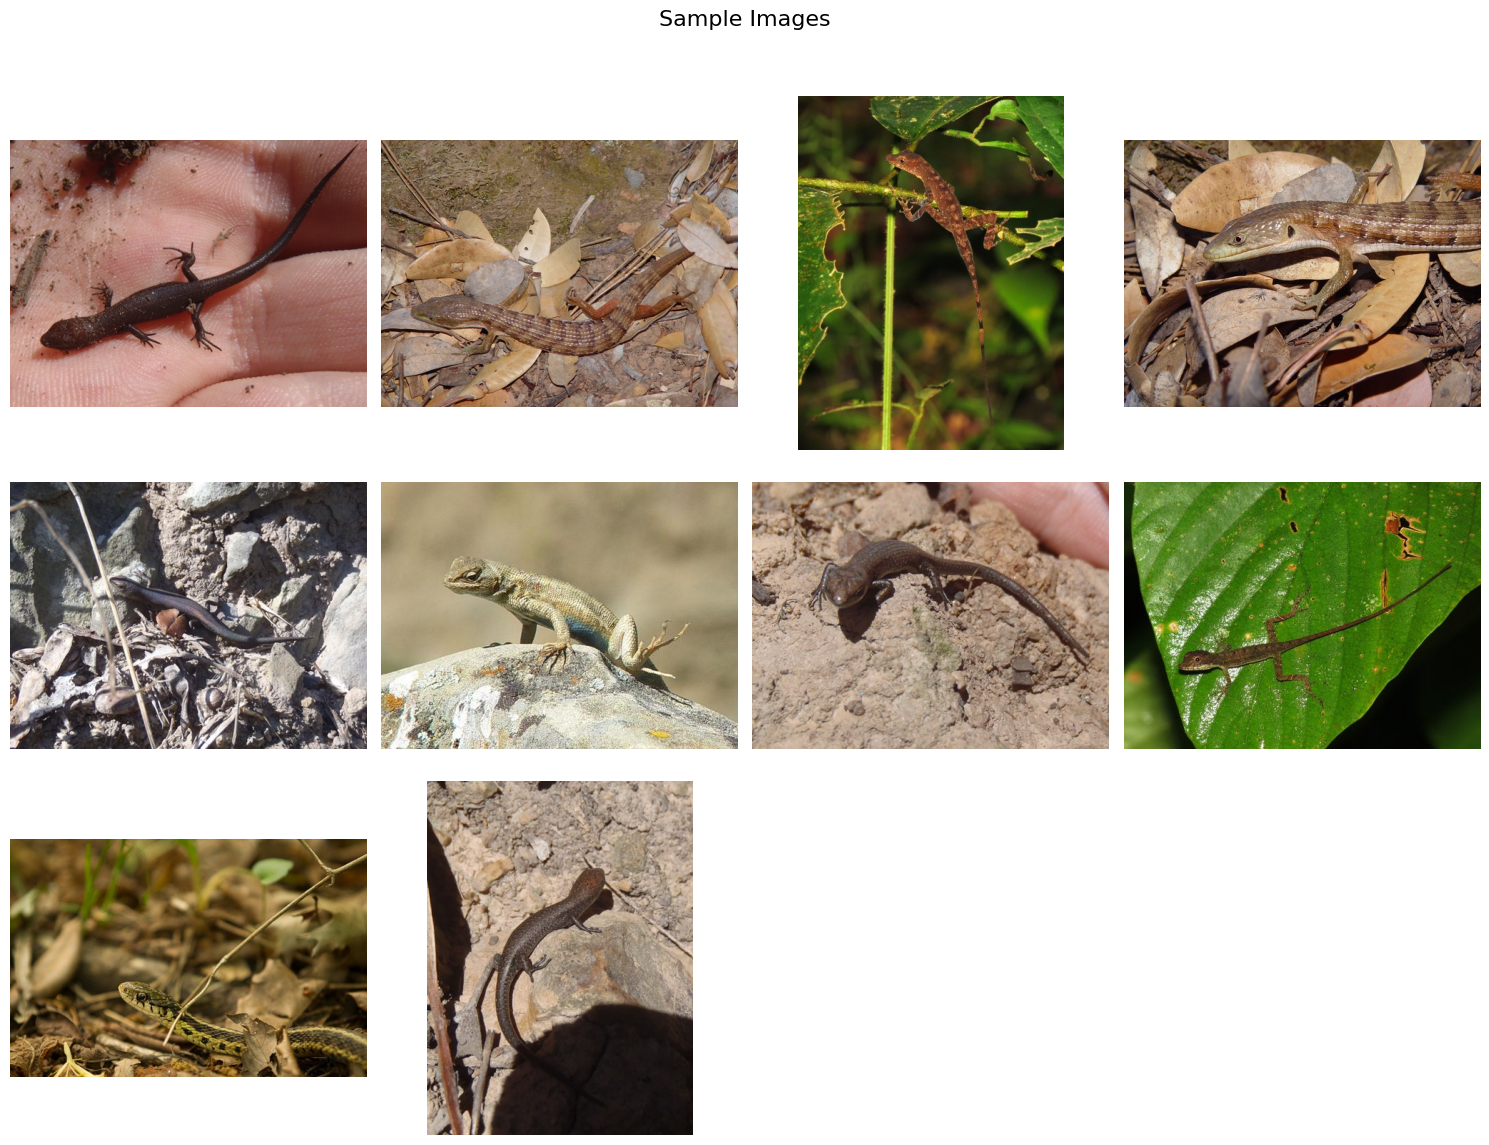

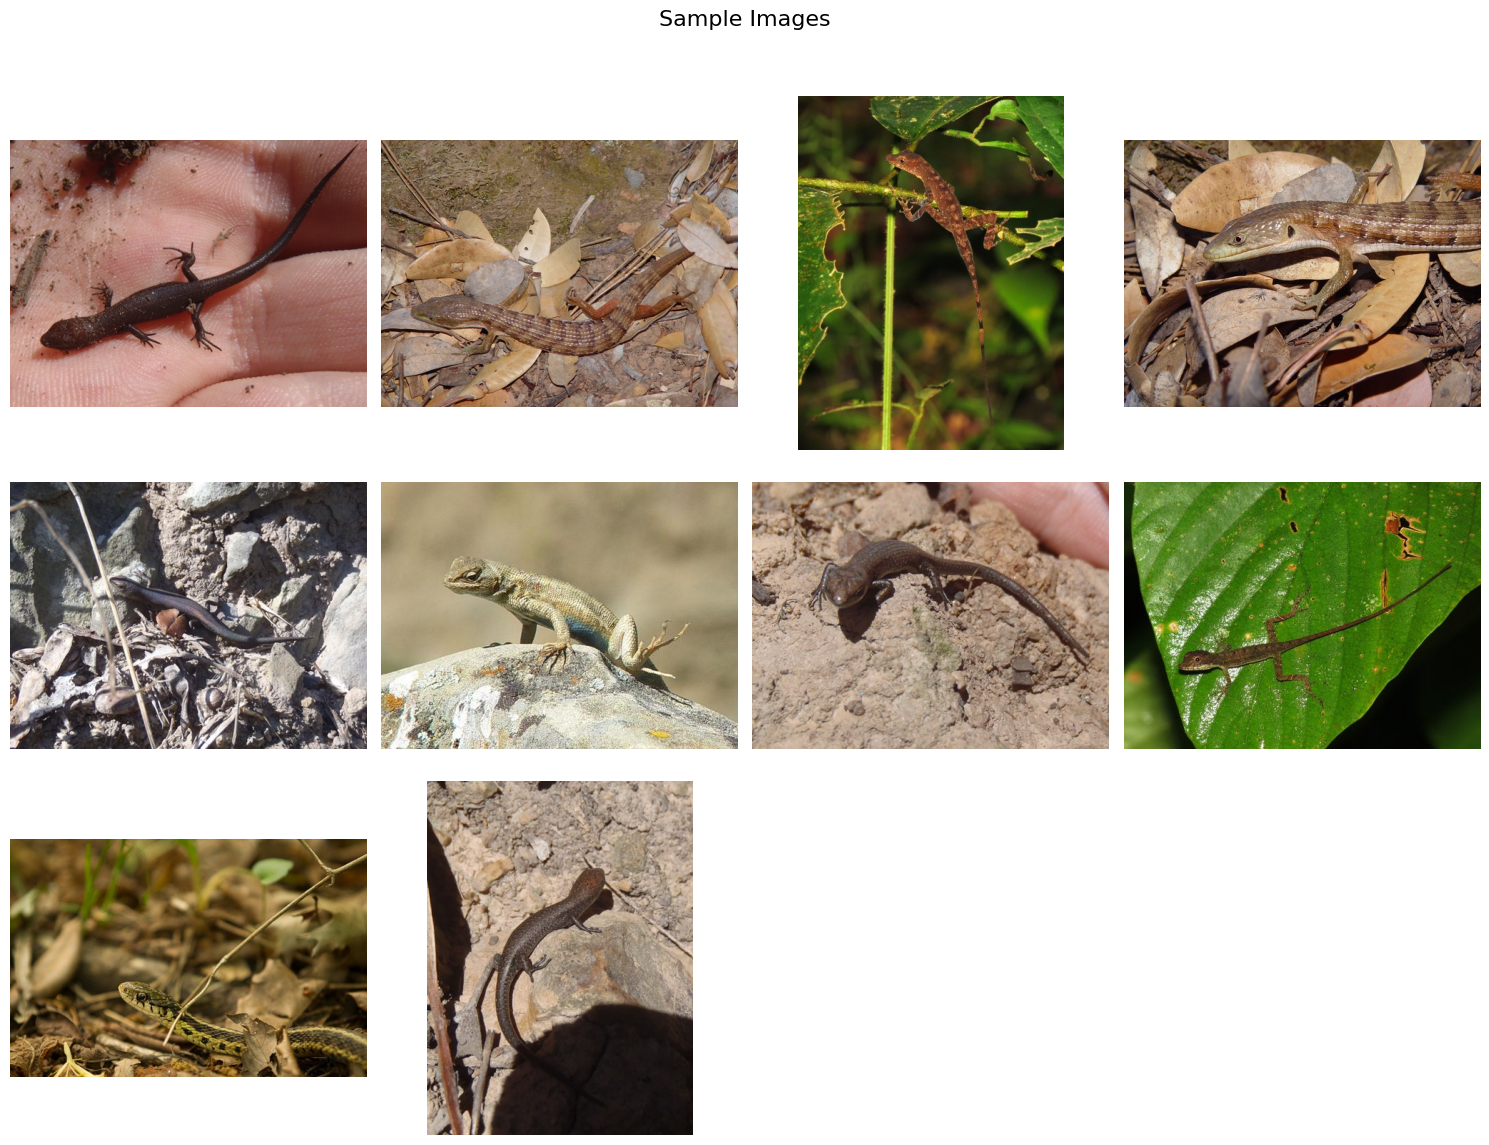

In [29]:
#@title Check for Outliers - Large
df["aspect_ratio"] = df["width"] / df["height"]

df_wide = df.sort_values(by="aspect_ratio", ascending=False).head(10)
df_tall = df.sort_values(by="aspect_ratio", ascending=True).head(10)

print("Wide images:")
display(df_wide)

print("Tall images:")
display(df_tall)

show_random_images(df_wide, n=min(10, len(df_wide)))
show_random_images(df_tall, n=min(10, len(df_tall)))

In [30]:
#@title Check for Duplicates
dup_sample = dup_groups.groupby("phash").head(2)  # two per duplicate group
show_random_images(dup_sample, n=min(12, len(dup_sample)))

No images to display from the provided DataFrame subset.
